In [6]:
from __future__ import print_function
import tensorflow.keras as keras
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from art.defences import AdversarialTrainer
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

from art.attacks import FastGradientMethod, ProjectedGradientDescent, PixelAttack
from art.classifiers import KerasClassifier
import numpy as np
import os

In [2]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        #if batch_normalization:
        #    x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        #if batch_normalization:
        #    x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [3]:
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr



In [12]:
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = False
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

#Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model = tfmot.quantization.keras.quantize_model(model)
    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_n

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 391 steps, validate on 10000 samples
Learning rate:  0.001
Epoch 1/200
391/391 [==============================] - 24s 62ms/step - loss: 1.8464 - accuracy: 0.4681 - val_loss: 1.6336 - val_accuracy: 0.5273
Learning rate:  0.001
Epoch 2/200
391/391 [==============================] - 20s 52ms/step - loss: 1.4274 - accuracy: 0.6049 - val_loss: 1.6791 - val_accuracy: 0.5482
Learning rate:  0.001
Epoch 3/200
391/391 [==============================] - 21s 53ms/step - loss: 1.2291 - accuracy: 0.6691 - val_loss: 1.2182 - val_accuracy: 0.6724
Learning rate:  0.001
Epoch 4/200
391/391 [==============================] - 21s 55ms/step - loss: 1.1044 - accuracy: 0.7103 - val_loss: 1.3946 - val_accuracy: 0.6401
Learning rate:  0.001
Epoch 5/200
391/391 [==============================] - 22s 56ms/step - loss: 1.0093 - accuracy: 0.7400 - val_loss: 1.0954 - val_accuracy: 0.7212
Learning rate:  0

Learning rate:  0.001
Epoch 25/200
391/391 [==============================] - 21s 53ms/step - loss: 0.5576 - accuracy: 0.8775 - val_loss: 0.8276 - val_accuracy: 0.8081
Learning rate:  0.001
Epoch 26/200
391/391 [==============================] - 23s 59ms/step - loss: 0.5553 - accuracy: 0.8781 - val_loss: 0.8703 - val_accuracy: 0.7887
Learning rate:  0.001
Epoch 27/200
391/391 [==============================] - 25s 63ms/step - loss: 0.5459 - accuracy: 0.8824 - val_loss: 0.8449 - val_accuracy: 0.8098
Learning rate:  0.001
Epoch 28/200
391/391 [==============================] - 25s 63ms/step - loss: 0.5364 - accuracy: 0.8839 - val_loss: 0.7391 - val_accuracy: 0.8256
Learning rate:  0.001
Epoch 29/200
391/391 [==============================] - 25s 63ms/step - loss: 0.5282 - accuracy: 0.8867 - val_loss: 0.8423 - val_accuracy: 0.7986
Learning rate:  0.001
Epoch 30/200
391/391 [==============================] - 25s 63ms/step - loss: 0.5254 - accuracy: 0.8860 - val_loss: 1.0731 - val_accuracy:

Learning rate:  0.001
Epoch 50/200
391/391 [==============================] - 25s 63ms/step - loss: 0.4502 - accuracy: 0.9128 - val_loss: 0.7409 - val_accuracy: 0.8310
Learning rate:  0.001
Epoch 51/200
391/391 [==============================] - 25s 63ms/step - loss: 0.4520 - accuracy: 0.9114 - val_loss: 0.7779 - val_accuracy: 0.8272
Learning rate:  0.001
Epoch 52/200
391/391 [==============================] - 25s 63ms/step - loss: 0.4413 - accuracy: 0.9157 - val_loss: 0.7755 - val_accuracy: 0.8161
Learning rate:  0.001
Epoch 53/200
391/391 [==============================] - 25s 63ms/step - loss: 0.4475 - accuracy: 0.9139 - val_loss: 0.6228 - val_accuracy: 0.8605
Learning rate:  0.001
Epoch 54/200
391/391 [==============================] - 20s 51ms/step - loss: 0.4369 - accuracy: 0.9171 - val_loss: 0.8073 - val_accuracy: 0.8198
Learning rate:  0.001
Epoch 55/200
391/391 [==============================] - 20s 52ms/step - loss: 0.4350 - accuracy: 0.9173 - val_loss: 0.6788 - val_accuracy:

Learning rate:  0.001
Epoch 75/200
391/391 [==============================] - 21s 54ms/step - loss: 0.4026 - accuracy: 0.9284 - val_loss: 0.7501 - val_accuracy: 0.8365
Learning rate:  0.001
Epoch 76/200
391/391 [==============================] - 21s 54ms/step - loss: 0.4065 - accuracy: 0.9262 - val_loss: 0.6396 - val_accuracy: 0.8552
Learning rate:  0.001
Epoch 77/200
391/391 [==============================] - 23s 60ms/step - loss: 0.4025 - accuracy: 0.9278 - val_loss: 0.7582 - val_accuracy: 0.8423
Learning rate:  0.001
Epoch 78/200
391/391 [==============================] - 25s 64ms/step - loss: 0.4023 - accuracy: 0.9287 - val_loss: 0.6431 - val_accuracy: 0.8634
Learning rate:  0.001
Epoch 79/200
391/391 [==============================] - 25s 64ms/step - loss: 0.4049 - accuracy: 0.9280 - val_loss: 0.8589 - val_accuracy: 0.8229
Learning rate:  0.001
Epoch 80/200
391/391 [==============================] - 25s 63ms/step - loss: 0.3987 - accuracy: 0.9296 - val_loss: 0.7311 - val_accuracy:

Learning rate:  0.0001
Epoch 100/200
391/391 [==============================] - 22s 56ms/step - loss: 0.2147 - accuracy: 0.9848 - val_loss: 0.4981 - val_accuracy: 0.9116
Learning rate:  0.0001
Epoch 101/200
391/391 [==============================] - 25s 64ms/step - loss: 0.2130 - accuracy: 0.9850 - val_loss: 0.5182 - val_accuracy: 0.9065
Learning rate:  0.0001
Epoch 102/200
391/391 [==============================] - 21s 53ms/step - loss: 0.2085 - accuracy: 0.9857 - val_loss: 0.5236 - val_accuracy: 0.9077
Learning rate:  0.0001
Epoch 103/200
391/391 [==============================] - 21s 54ms/step - loss: 0.2062 - accuracy: 0.9862 - val_loss: 0.5042 - val_accuracy: 0.9090
Learning rate:  0.0001
Epoch 104/200
391/391 [==============================] - 21s 54ms/step - loss: 0.2040 - accuracy: 0.9864 - val_loss: 0.5133 - val_accuracy: 0.9087
Learning rate:  0.0001
Epoch 105/200
391/391 [==============================] - 21s 54ms/step - loss: 0.2028 - accuracy: 0.9862 - val_loss: 0.5186 - v

Learning rate:  1e-05
Epoch 125/200
391/391 [==============================] - 21s 53ms/step - loss: 0.1640 - accuracy: 0.9931 - val_loss: 0.5034 - val_accuracy: 0.9125
Learning rate:  1e-05
Epoch 126/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1625 - accuracy: 0.9934 - val_loss: 0.5037 - val_accuracy: 0.9122
Learning rate:  1e-05
Epoch 127/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1629 - accuracy: 0.9935 - val_loss: 0.5053 - val_accuracy: 0.9125
Learning rate:  1e-05
Epoch 128/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1620 - accuracy: 0.9936 - val_loss: 0.5032 - val_accuracy: 0.9122
Learning rate:  1e-05
Epoch 129/200
391/391 [==============================] - 21s 55ms/step - loss: 0.1609 - accuracy: 0.9941 - val_loss: 0.5024 - val_accuracy: 0.9122
Learning rate:  1e-05
Epoch 130/200
391/391 [==============================] - 22s 57ms/step - loss: 0.1619 - accuracy: 0.9933 - val_loss: 0.5020 - val_acc

Learning rate:  1e-05
Epoch 150/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1559 - accuracy: 0.9947 - val_loss: 0.5030 - val_accuracy: 0.9127
Learning rate:  1e-05
Epoch 151/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1541 - accuracy: 0.9954 - val_loss: 0.5042 - val_accuracy: 0.9135
Learning rate:  1e-05
Epoch 152/200
391/391 [==============================] - 21s 55ms/step - loss: 0.1556 - accuracy: 0.9945 - val_loss: 0.5052 - val_accuracy: 0.9137
Learning rate:  1e-05
Epoch 153/200
391/391 [==============================] - 25s 65ms/step - loss: 0.1549 - accuracy: 0.9948 - val_loss: 0.5054 - val_accuracy: 0.9131
Learning rate:  1e-05
Epoch 154/200
391/391 [==============================] - 26s 66ms/step - loss: 0.1550 - accuracy: 0.9942 - val_loss: 0.5074 - val_accuracy: 0.9124
Learning rate:  1e-05
Epoch 155/200
391/391 [==============================] - 26s 66ms/step - loss: 0.1538 - accuracy: 0.9952 - val_loss: 0.5064 - val_acc

Learning rate:  1e-06
Epoch 175/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1517 - accuracy: 0.9953 - val_loss: 0.5098 - val_accuracy: 0.9124
Learning rate:  1e-06
Epoch 176/200
391/391 [==============================] - 22s 55ms/step - loss: 0.1513 - accuracy: 0.9954 - val_loss: 0.5094 - val_accuracy: 0.9128
Learning rate:  1e-06
Epoch 177/200
391/391 [==============================] - 21s 54ms/step - loss: 0.1518 - accuracy: 0.9950 - val_loss: 0.5084 - val_accuracy: 0.9131
Learning rate:  1e-06
Epoch 178/200
391/391 [==============================] - 21s 55ms/step - loss: 0.1518 - accuracy: 0.9955 - val_loss: 0.5088 - val_accuracy: 0.9132
Learning rate:  1e-06
Epoch 179/200
391/391 [==============================] - 21s 55ms/step - loss: 0.1514 - accuracy: 0.9957 - val_loss: 0.5091 - val_accuracy: 0.9129
Learning rate:  1e-06
Epoch 180/200
391/391 [==============================] - 22s 57ms/step - loss: 0.1513 - accuracy: 0.9956 - val_loss: 0.5082 - val_acc

Learning rate:  5e-07
Epoch 200/200
391/391 [==============================] - 26s 66ms/step - loss: 0.1512 - accuracy: 0.9954 - val_loss: 0.5075 - val_accuracy: 0.9138


In [6]:
model.save('Resnet18-200epochs.h5')

In [7]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 213us/sample - loss: 0.5075 - accuracy: 0.9138
Test loss: 0.5075194211006164
Test accuracy: 0.9138


## Quantization Aware Training 

In [13]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

#Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model = tfmot.quantization.keras.quantize_model(model)
    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 391 steps, validate on 10000 samples
Learning rate:  0.001
Epoch 1/100
391/391 [==============================] - 62s 160ms/step - loss: 2.1336 - accuracy: 0.3536 - val_loss: 1.9176 - val_accuracy: 0.4181
Learning rate:  0.001
Epoch 2/100
391/391 [==============================] - 48s 123ms/step - loss: 1.7424 - accuracy: 0.4876 - val_loss: 1.6491 - val_accuracy: 0.5116
Learning rate:  0.001
Epoch 3/100
391/391 [==============================] - 47s 120ms/step - loss: 1.5520 - accuracy: 0.5551 - val_loss: 1.5222 - val_accuracy: 0.5598
Learning rate:  0.001
Epoch 4/100
391/391 [==============================] - 49s 125ms/step - loss: 1.4016 - accuracy: 0.6052 - val_loss: 1.3031 - val_accuracy: 0.6420
Learning rate:  0.001
Epoch 5/100
391/391 [==============================] - 49s 125ms/step - loss: 1.2994 - accuracy: 0.6425 - val_loss: 1.2483 - val_accuracy: 0.6554
Learning rat

Learning rate:  0.001
Epoch 25/100
391/391 [==============================] - 50s 128ms/step - loss: 0.6956 - accuracy: 0.8404 - val_loss: 0.7508 - val_accuracy: 0.8198
Learning rate:  0.001
Epoch 26/100
391/391 [==============================] - 50s 128ms/step - loss: 0.6922 - accuracy: 0.8420 - val_loss: 0.8035 - val_accuracy: 0.8153
Learning rate:  0.001
Epoch 27/100
391/391 [==============================] - 48s 123ms/step - loss: 0.6721 - accuracy: 0.8479 - val_loss: 0.7856 - val_accuracy: 0.8154
Learning rate:  0.001
Epoch 28/100
391/391 [==============================] - 48s 124ms/step - loss: 0.6641 - accuracy: 0.8508 - val_loss: 0.7534 - val_accuracy: 0.8273
Learning rate:  0.001
Epoch 29/100
391/391 [==============================] - 48s 123ms/step - loss: 0.6654 - accuracy: 0.8504 - val_loss: 0.7608 - val_accuracy: 0.8276
Learning rate:  0.001
Epoch 30/100
391/391 [==============================] - 48s 123ms/step - loss: 0.6492 - accuracy: 0.8559 - val_loss: 0.7719 - val_acc

Learning rate:  0.001
Epoch 50/100
391/391 [==============================] - 50s 128ms/step - loss: 0.5394 - accuracy: 0.8906 - val_loss: 0.6797 - val_accuracy: 0.8541
Learning rate:  0.001
Epoch 51/100
391/391 [==============================] - 50s 128ms/step - loss: 0.5329 - accuracy: 0.8937 - val_loss: 0.7073 - val_accuracy: 0.8458
Learning rate:  0.001
Epoch 52/100
391/391 [==============================] - 50s 129ms/step - loss: 0.5360 - accuracy: 0.8917 - val_loss: 0.6956 - val_accuracy: 0.8519
Learning rate:  0.001
Epoch 53/100
391/391 [==============================] - 48s 122ms/step - loss: 0.5312 - accuracy: 0.8956 - val_loss: 0.7290 - val_accuracy: 0.8448
Learning rate:  0.001
Epoch 54/100
391/391 [==============================] - 48s 123ms/step - loss: 0.5254 - accuracy: 0.8962 - val_loss: 0.7040 - val_accuracy: 0.8519
Learning rate:  0.001
Epoch 55/100
391/391 [==============================] - 50s 127ms/step - loss: 0.5252 - accuracy: 0.8942 - val_loss: 0.6691 - val_acc

Learning rate:  0.001
Epoch 75/100
391/391 [==============================] - 50s 129ms/step - loss: 0.4810 - accuracy: 0.9097 - val_loss: 0.6964 - val_accuracy: 0.8589
Learning rate:  0.001
Epoch 76/100
391/391 [==============================] - 50s 129ms/step - loss: 0.4769 - accuracy: 0.9113 - val_loss: 0.6724 - val_accuracy: 0.8642
Learning rate:  0.001
Epoch 77/100
391/391 [==============================] - 48s 122ms/step - loss: 0.4745 - accuracy: 0.9126 - val_loss: 0.6913 - val_accuracy: 0.8554
Learning rate:  0.001
Epoch 78/100
391/391 [==============================] - 49s 124ms/step - loss: 0.4712 - accuracy: 0.9143 - val_loss: 0.8094 - val_accuracy: 0.8388
Learning rate:  0.001
Epoch 79/100
391/391 [==============================] - 50s 129ms/step - loss: 0.4727 - accuracy: 0.9115 - val_loss: 0.7185 - val_accuracy: 0.8531
Learning rate:  0.001
Epoch 80/100
391/391 [==============================] - 50s 129ms/step - loss: 0.4687 - accuracy: 0.9148 - val_loss: 0.6609 - val_acc

Learning rate:  0.0001
Epoch 100/100
391/391 [==============================] - 50s 129ms/step - loss: 0.2879 - accuracy: 0.9719 - val_loss: 0.6658 - val_accuracy: 0.8885


In [14]:
model.save('QAT-Resnet18.h5')

## Inference

In [9]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [11]:
with tfmot.quantization.keras.quantize_scope():
    model = tf.keras.models.load_model('QAT-Resnet18.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected an indented block (<unknown>, line 14)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

In [19]:
classifier = KerasClassifier(model=model, clip_values=None, use_logits=False)

In [15]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if True:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [17]:
from numpy import load
data = load('fgsmtest(0.01).npy') # attack images of the resnet-200 epoch model, not quantized
predictions = model.predict(data)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on fgsm 0.1 test examples: {}%".format(accuracy * 100))

Accuracy on fgsm 0.1 test examples: 76.94%


In [21]:
fgsm1 = FastGradientMethod(classifier, eps=0.03)
test = fgsm1.generate(x_test)
predictions = model.predict(test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on fgsm 0.03 test examples: {}%".format(accuracy * 100))

Accuracy on fgsm 0.03 test examples: 21.790000000000003%


In [9]:
from art.defences import *

In [10]:
ss = SpatialSmoothing(window_size=3)

x_art_def, _ = ss(x_test)
x_art_adv_def, _ = ss(x_test_adv)

pred1 = classifier.predict(x_art_def)
pred2 = classifier.predict(x_art_adv_def)

accuracy = np.sum(np.argmax(pred1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

accuracy = np.sum(np.argmax(pred2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 81.95%
Accuracy on adversarial test examples: 14.899999999999999%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


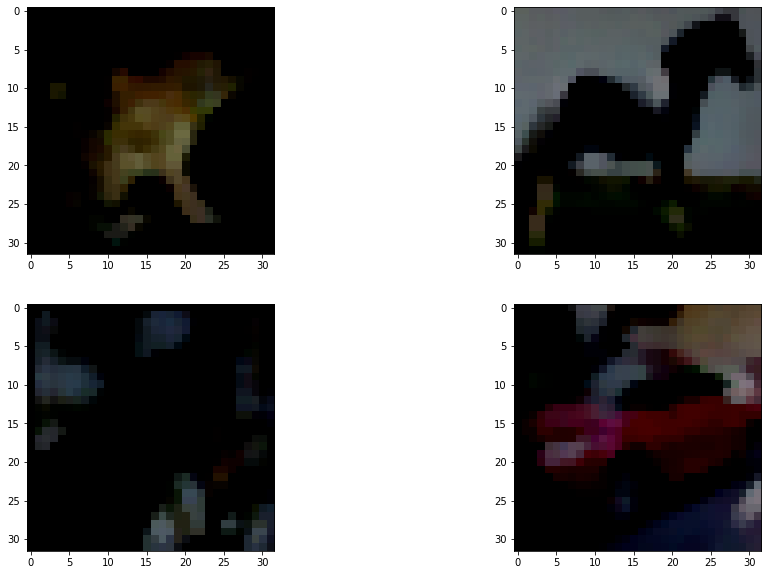

In [47]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16,10))

for i in range(2):
    for j in range(2):
        axes[i, j].imshow(x_art_adv_def[np.random.randint(10000, size=1)[0]][:,:,:])